In [1]:
%pylab inline

from __future__ import division
from time import strftime
from calendar import monthrange
from datetime import datetime, date, timedelta
print strftime('%Y-%m-%d %X'), 'clock set'
import random
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, scale
from sklearn import svm, linear_model, neighbors
from sklearn.grid_search import GridSearchCV

Populating the interactive namespace from numpy and matplotlib
2015-05-30 02:25:52 clock set


In [2]:
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
train = pd.read_csv('../input/train.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Species', 'Latitude', 'Longitude', 'WnvPresent']]
print train.shape

(10506, 5)


In [3]:
train['Year'] = map(lambda x: x.year, train['Date'])
train['DayOfYear'] = map(lambda x: x.timetuple().tm_yday, train['Date'])

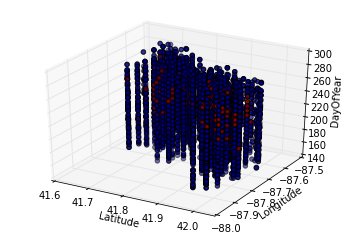

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['Latitude'], train['Longitude'], train['DayOfYear'], c=train['WnvPresent'])

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('DayOfYear')

In [5]:
train['Latitude'] = scale(train['Latitude'])
train['Longitude'] = scale(train['Longitude'])
train['DayOfYear'] = scale(map(float, train['DayOfYear']))

In [6]:
mask = np.random.rand(len(train)) <= 1
trainMini = train[mask]
print len(trainMini)

10506


In [7]:
# how come suddenly slow?
# n_jobs != 1 and verbose > 0 seems to make it grind to a halt, avoid this combination!

# cluster on, no verbose
# .2 data, n_jobs = 1, C -1 1 3, gamma -1 1 3 : time = 0:10
# .5 data, n_jobs = 1, C -1 3 3, gamma -3 1 3 : time = 2:20
# .5 data, n_jobs = 1, C -1 3 3, gamma -3 1 3, verbose = 5 : time = 2:20 -- most is C = 1000, gamma = 0.1
# .5 data, n_jobs = 2, C -1 3 3, gamma -3 1 3, not verbose! : time = 1:44
# .5 data, n_jobs = 3, C -1 3 3, gamma -3 1 3, not verbose! : time = 1:20
# .5 data, n_jobs = 4, C -1 3 3, gamma -3 1 3, not verbose! : time = 1:13

# set cv=2 should reduce time which is ok for now
# .5 data, n_jobs = 1, C -1 3 3, gamma -3 1 3, not verbose! : time = 0:45
# .5 data, n_jobs = 1, C -1 3 3, gamma -3 1 3, verbose = 5 : time = 0:49
# .5 data, n_jobs = 4, C -1 3 3, gamma -3 1 3, not verbose! : time = 0:36
# above C, gamma are log scale. below is absolute scale

# try upping the C to improve accuracy (data still .5)
# .5 data, n_jobs = 1, C 10 300 1000, gamma 0.0001, verbose = 5 : time = 0:03
# .5 data, n_jobs = 1, C 1000 3000 10000 30000 100000, gamma 0.00001 0.0001, verbose = 5 : time = 0:07

# more data:
# .9 data, n_jobs = 1, C 1000 3000 10000 30000 100000, gamma 0.00001 0.0001 0.001, verbose = 5 : time = 1:12
# .9 data, n_jobs = 1, C 1000 3000 10000 30000 100000, gamma 0.00001 0.0001 0.001, not verbose : time = 1:15
# .9 data, n_jobs = 2, C 1000 3000 10000 30000 100000, gamma 0.00001 0.0001 0.001, not verbose : time = 0:47
# .9 data, n_jobs = 3, C 1000 3000 10000 30000 100000, gamma 0.00001 0.0001 0.001, not verbose : time = 0:42
# .9 data, n_jobs = 4, C 1000 3000 10000 30000 100000, gamma 0.00001 0.0001 0.001, not verbose : time = 0:37

# add gamma = 0.01 (slow?)
# 1 data, n_jobs = 4, C 1000 3000 10000 30000 100000, gamma 0.00001 0.0001 0.001 0.01, not verbose : time = 4:09

print strftime('%Y-%m-%d %X'), 'clock set'

C_range = [10000, 30000]
gamma_range = [0.0001, 0.001]

param_grid = dict(gamma=gamma_range, C=C_range)

clf = GridSearchCV(svm.SVC(), param_grid=param_grid, scoring='roc_auc', n_jobs=4, cv=2)
#clf = GridSearchCV(svm.SVC(), param_grid=param_grid)#, n_jobs=-1, scoring='roc_auc', verbose=5)
clf.fit(trainMini[['Latitude', 'Longitude', 'DayOfYear']], trainMini['WnvPresent'])

print strftime('%Y-%m-%d %X'), 'clock set'
print
print 'best:', clf.best_params_
print
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))

2015-05-30 02:25:56 clock set
2015-05-30 02:26:17 clock set

best: {'C': 30000, 'gamma': 0.0001}

0.750 (+/-0.039) for {'C': 10000, 'gamma': 0.0001}
0.724 (+/-0.036) for {'C': 10000, 'gamma': 0.001}
0.753 (+/-0.051) for {'C': 30000, 'gamma': 0.0001}
0.751 (+/-0.018) for {'C': 30000, 'gamma': 0.001}


In [8]:
svc = svm.SVC(C=clf.best_params_['C'], gamma=clf.best_params_['gamma'], probability=True)
svc.fit(trainMini[['Latitude', 'Longitude', 'DayOfYear']], trainMini['WnvPresent'])
Z = svc.predict_proba(trainMini[['Latitude', 'Longitude', 'DayOfYear']])

0.746800529789


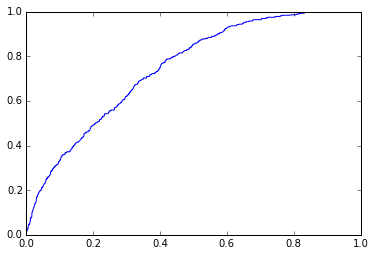

In [9]:
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
fpr, tpr, thresholds = roc_curve(trainMini['WnvPresent'], Z[:, 1])
print auc(fpr, tpr)
plt.plot(fpr, tpr)

In [10]:
# to do: add temperature

In [11]:
print strftime('%Y-%m-%d %X'), 'clock set'
test = pd.read_csv('../input/test.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Species', 'Latitude', 'Longitude']]
test['Year'] = map(lambda x: x.year, test['Date'])
test['DayOfYear'] = map(lambda x: x.timetuple().tm_yday, test['Date'])

test['Latitude'] = scale(test['Latitude'])
test['Longitude'] = scale(test['Longitude'])
test['DayOfYear'] = scale(map(float, test['DayOfYear']))
print strftime('%Y-%m-%d %X'), 'clock set'

Z = svc.predict_proba(test[['Latitude', 'Longitude', 'DayOfYear']])
print strftime('%Y-%m-%d %X'), 'clock set'

2015-05-30 02:26:41 clock set
2015-05-30 02:26:46 clock set
2015-05-30 02:26:49 clock set


In [12]:
with open('better-svc.csv', 'w') as f:
    f.write('Id,WnvPresent\n')
    for i in xrange(1, 116293 + 1):
        f.write(str(i) + ',' + str(Z[i - 1, 1]) + '\n')